# Load Dataset

In [1]:
import common
import cv2
import os
import pandas as pd
import numpy as np
import mediapipe as mp
from scipy.spatial import distance

In [2]:
mpHands = mp.solutions.hands
hands = mpHands.Hands(max_num_hands=2)

dataset_path = 'hand_dataset'

y = []
X = []

for directory in os.listdir(dataset_path):
    sign_path = os.path.join(dataset_path, directory)
    
    for file in os.listdir(sign_path):
        file_path = os.path.join(sign_path, file)

        img = cv2.imread(file_path, cv2.IMREAD_COLOR)
        h, w, c = img.shape
        img = cv2.flip(img, 1)
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(imgRGB)

        hand_landmarks = common.get_right_hand_landmarks(results, h, w)

        if hand_landmarks is False:
            print(f'Landmarks not found in: {file_path}')

        if hand_landmarks is not False:
            y.append(directory)
            normalized_landmarks = common.normalize_hand_landmarks(hand_landmarks)
            df = pd.DataFrame(normalized_landmarks)
            df.columns = ['x', 'y', 'z']
            df.drop('z', axis=1, inplace=True)
            features = df.to_numpy().flatten()

            X.append(features)

y = np.asarray(y)
X = np.asarray(X)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Landmarks not found in: hand_dataset/s/IMG_20220314_170645.jpg
Landmarks not found in: hand_dataset/m/IMG_20220314_170448.jpg
Landmarks not found in: hand_dataset/t/IMG_20220314_152113.jpg
Landmarks not found in: hand_dataset/e/IMG_20220314_170048.jpg
Landmarks not found in: hand_dataset/x/IMG_20220314_171623.jpg
Landmarks not found in: hand_dataset/d/IMG_20220314_170014.jpg
Landmarks not found in: hand_dataset/z/IMG_20220314_171650.jpg
Landmarks not found in: hand_dataset/z/IMG_20220314_171653.jpg
Landmarks not found in: hand_dataset/b/IMG_20220314_165930.jpg
Landmarks not found in: hand_dataset/b/IMG_20220314_165922.jpg
Landmarks not found in: hand_dataset/q/IMG_20220314_170600.jpg
Landmarks not found in: hand_dataset/q/IMG_20220314_170604.jpg
Landmarks not found in: hand_dataset/null/IMG_20220329_130119.jpg
Landmarks not found in: hand_dataset/null/IMG_20220315_134844.jpg
Landmarks not found in: hand_dataset/null/IMG_20220315_135248.jpg
Landmarks not found in: hand_dataset/null/IMG_

# Model Cross Validation

In [3]:
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC

In [4]:
loo = LeaveOneOut()

predicted_targets = np.array([])
actual_targets = np.array([])

for train_index, test_index in loo.split(X, y):
    X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]

    # Fit the classifier
    clf = SVC(kernel='poly', degree=3).fit(X_train, y_train)

    # Predict the labels of the test set samples
    predicted_labels = clf.predict(X_test)

    predicted_targets = np.append(predicted_targets, predicted_labels)
    actual_targets = np.append(actual_targets, y_test)

## Results

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

              precision    recall  f1-score   support

           a       0.94      1.00      0.97        16
           b       0.81      1.00      0.90        13
           c       0.78      0.64      0.70        11
           d       0.71      0.77      0.74        13
           e       0.86      0.86      0.86        14
           f       0.85      0.73      0.79        15
           g       0.94      1.00      0.97        15
           h       0.88      0.94      0.91        16
           i       0.89      0.80      0.84        20
           j       0.88      0.82      0.85        17
           k       1.00      1.00      1.00        15
           l       0.94      1.00      0.97        15
           m       0.68      0.93      0.79        14
           n       1.00      0.85      0.92        13
        null       0.79      0.76      0.78        25
           o       0.70      0.93      0.80        15
           p       0.93      0.93      0.93        15
           q       0.92    

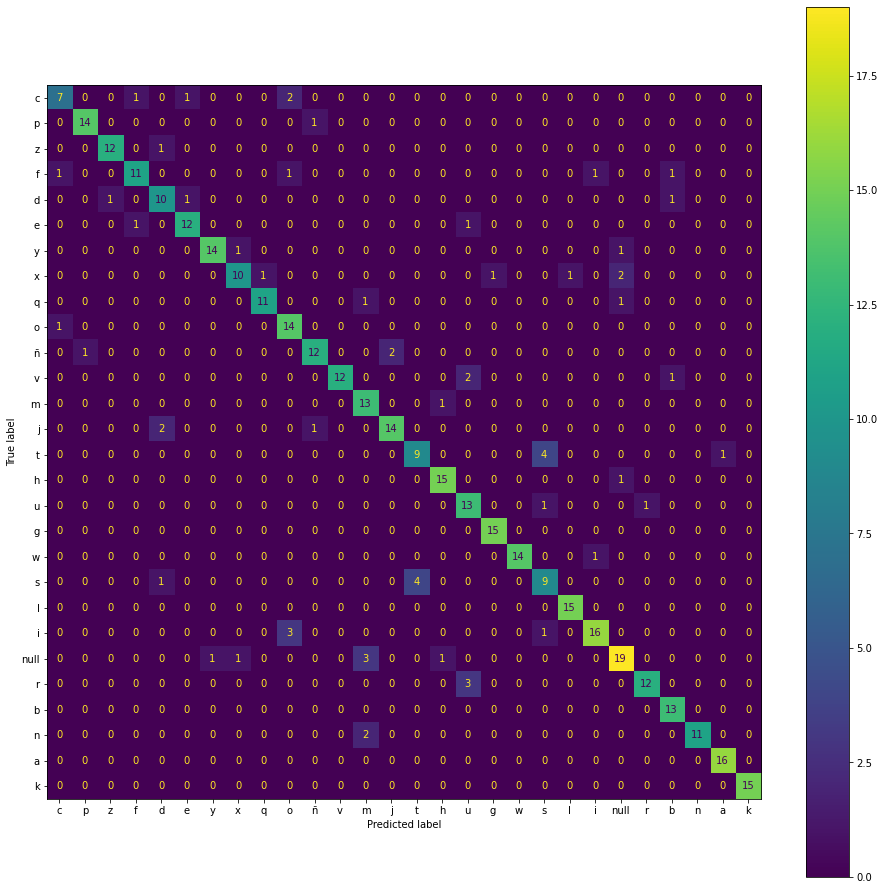

In [8]:
labels = list(set(y))
cm = confusion_matrix(actual_targets, predicted_targets, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(16,16))
disp.plot(ax=ax)
print(classification_report(actual_targets, predicted_targets))